In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

Hyper parameters

In [27]:
WINDOW_SIZE=30
BATCH_SIZE=64

股票資料使用從2024-02-15到2025-05-23共天(但實際只有天,因為每天的明天要作為當天的ground truth,所以最後一天刪除只做為的label)

In [6]:
# 讀取股票資料
stock_data = pd.read_csv('./tmp/stock_data_2.csv', dtype={"stock_code": str, "date": str})
stock_data.set_index(["stock_code", "date"], inplace=True)
stock_data.sort_index(inplace=True)

In [7]:
stock_data.head()

capacity    turnover    high     low   close  change  \
stock_code date                                                             
0050       20240215  44444918  6313384766  142.70  141.40  142.35    6.40   
           20240216  18273199  2589642250  142.35  141.20  141.30   -1.05   
           20240219   9632521  1357473487  141.25  140.60  141.10   -0.20   
           20240220  13875231  1965919655  142.00  140.40  141.65    0.55   
           20240221  10780271  1523264833  141.50  141.05  141.20   -0.45   

                     transaction_volume  stock_code_id    open  
stock_code date                                                 
0050       20240215               44592             50  142.20  
           20240216               14623             50  142.35  
           20240219               12669             50  141.00  
           20240220               11241             50  140.55  
           20240221               13385             50  141.40

訓練輸入股票特徵選用6種並對其資料做Z-score標準化

In [11]:
stocks_data_frame = []
scaler = StandardScaler()

# 定義訓練資料集
all_stock_data = []
for stock_code in stock_data.index.get_level_values(0).unique():
    stock_df = pd.DataFrame({
        'open': stock_data.loc[stock_code]['open'],#開盤價
        'close': stock_data.loc[stock_code]['close'],#收盤價'
        'high': stock_data.loc[stock_code]['high'],#最高價
        'low': stock_data.loc[stock_code]['low'],#最低價
        'volume': stock_data.loc[stock_code]['transaction_volume'],#成交量
        'change': stock_data.loc[stock_code]['change'],#漲跌幅
    })
    all_stock_data.append(stock_df)

# 將所有股票資料合併成一個大DataFrame
combined_df = pd.concat(all_stock_data, ignore_index=True)

# 對所有股票的數值欄位進行Z-score標準化
numeric_columns = ['open', 'close', 'high', 'low', 'volume', 'change']
scaler.fit(combined_df[numeric_columns])

# 將標準化後的資料分回各個股票
for df in all_stock_data:
    df[numeric_columns] = scaler.transform(df[numeric_columns])
    stocks_data_frame.append(df)

# 儲存scaler供之後使用
import joblib
joblib.dump(scaler, './model/scaler.pkl')
print(stocks_data_frame)
    
    


[              open     close      high       low    volume    change
date                                                                
20240215  0.286903  0.290124  0.277762  0.297532  1.138431  0.822047
20240216  0.287671  0.284741  0.276008  0.296487  0.308115 -0.106034
20240219  0.280763  0.283716  0.270493  0.293352  0.253977 -0.000146
20240220  0.278461  0.286535  0.274253  0.292307  0.214413  0.093285
20240221  0.282810  0.284228  0.271746  0.295703  0.273815 -0.031290
...            ...       ...       ...       ...       ...       ...
20250519  0.493864  0.485446  0.478045  0.501035  0.806404 -0.292896
20250520  0.489771  0.487241  0.476792  0.501818  0.321247  0.068370
20250521  0.484910  0.501595  0.484061  0.503908  0.466814  0.373578
20250522  0.490794  0.491342  0.475037  0.502341  0.434647 -0.224380
20250523  0.494376  0.487497  0.478797  0.500251  0.420268 -0.068662

[293 rows x 6 columns],               open     close      high       low    volume    change
date    

刪除那些在這段期間不足10筆資料的股票

In [13]:
# 檢查並刪除不符合(62,4)大小的資料框
abnormal_stocks = []
for i in range(len(stocks_data_frame)):
    if stocks_data_frame[i].shape[0] < 10:
        abnormal_stocks.append(i)

#將原本資料刪除這些不完整的股票
stocks_data_frame = [df for i, df in enumerate(stocks_data_frame) if i not in abnormal_stocks]

print(f"刪除後剩餘股票數量: {len(stocks_data_frame)}")

刪除後剩餘股票數量: 2096


將所有股票資料同一天的concat到同一row=>shape=(天數,股票數量*特徵數)

使模型能夠學習不同股票間的關連性

替剩餘每支股票建立一個整數ID供之後模型embedding輸入

In [182]:
# # 從list中取得所有不重複的股票代碼
# ids = []
# for df in stocks_data_frame:
#     code = df['stock_code'].iloc[0]#取得資料中所有stock code
#     if code not in ids:
#         ids.append(code)
# stock_code_to_id = {code: idx for idx, code in enumerate(ids)}#建立一個映射表

In [ ]:
# print(stock_code_to_id)

In [177]:
# # 刪除 stock_code 欄位
# for df in stocks_data_frame:
#     df.drop('stock_code', axis=1, inplace=True)

In [118]:
# #將剩餘股票中的股票代碼用獨立整數id替代
# for df in stocks_data_frame:
#     df['stock_code'] = df['stock_code'].map(stock_code_to_id)

將每支股票資料往前移一天作為label供訓練,並只取change作訓練

In [14]:
#將所有股票往前一天移動來產生預測label
#因為最後只要預測漲跌幅,所有change_labels只儲存labels中change的col
labels = []
shifted_labels=[]
shifted_stocks = []

for stock_df in stocks_data_frame:
    # 產生label
    labels = stock_df.shift(-1)
    labels = labels.iloc[:-1]  # 刪除最後一天(NaN)
    
    # 只取每5個column的change作為label
    change_cols = [col for col in labels.columns if 'change' in col]
    labels = labels[change_cols]
    shifted_labels.append(labels)
    
    # 刪除最後一天資料與label統一
    new_df = stock_df.iloc[:-1]
    shifted_stocks.append(new_df)



In [18]:
shifted_stocks[-1]['change']

date
20240505    0.030998
20240507    0.006083
20240508    0.012312
20240509    0.037226
20240510    0.024769
              ...   
20250516    0.030998
20250519    0.024769
20250520    0.024769
20250521    0.030998
20250522    0.030998
Name: change, Length: 234, dtype: float64

In [15]:
shifted_labels[-1]

,change
date,
20240505,0.006083
20240507,0.012312
20240508,0.037226
20240509,0.024769
20240510,0.006083
...,...
20250516,0.024769
20250519,0.024769
20250520,0.030998


使用sliding windows來處理data,設定window size=30

In [20]:
def create_seq_data(stocks,labels,seq_size):
    seq=[]#裝每支股票經過windows切分過後的資料
    seq_label=[]#裝每支股票中每個window的label

    for stock,label in zip(stocks,labels):
        for i in range(len(stock)-seq_size+1):
            seq.append(stock.iloc[i:i+seq_size])
            seq_label.append(label.iloc[i+seq_size-1])

    return np.array(seq), np.array(seq_label)

用每30天作為一筆資料並預測第31天的change來將資料切分data和Label為時間序列模型可輸入的資料

In [21]:
x,y=create_seq_data(shifted_stocks,shifted_labels,WINDOW_SIZE)

x(Data) shape:(每支股票切分後的window數*有幾檔股票,window size,特徵數)

y(Label) shape:(每支股票切分後的window數*有幾檔股票)

In [23]:
print(x.shape)
print(y.shape)

(496116, 30, 6)
(496116, 1)


將以上資料切分成訓練集和測試集並準備Data Loader

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    x, 
    y,
    test_size=0.2,#驗證集佔20%
    shuffle=False  
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)



train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)



準備模型(使用Encoder-only 的Transformer)

In [38]:
class StockTransformer(nn.Module):
    def __init__(self,input_dim,d_model,nhead,num_layers,dropout):
        super().__init__()
        self.input_dim=input_dim
        self.d_model=d_model
        #將輸入維度轉為d_model
        self.feature_embedding = nn.Linear(input_dim, d_model)
        #加入positional encoding(用learnable para)
        self.positional_encoding=nn.Parameter(torch.rand(1,WINDOW_SIZE,d_model))
        #Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        #輸出回歸層
        self.regressor = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )
    def forward(self,x):
        x=self.feature_embedding(x)
        x=x+self.positional_encoding
        encoded=self.encoder(x)
        last=encoded[:,-1,:]
        output=self.regressor(last)

        return output


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


建立模型以及設定參數

In [39]:
model = StockTransformer(input_dim=6,d_model=64,nhead=4,num_layers=2,dropout=0.1).to(device)

In [41]:
print(model)

StockTransformer(
  (feature_embedding): Linear(in_features=6, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


設定Loss function和optimizer


In [32]:
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device).float()   # (B, 10, 6)
        y_batch = y_batch.to(device).float()   # (B, 1)

        optimizer.zero_grad()
        preds = model(X_batch)                # shape: (B, 1)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)


訓練並記錄訓練結果和儲存模型

In [43]:
EPOCHS = 40

train_losses=[]
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = eval_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
#儲存模型
torch.save(model.state_dict(), "stock_transformer_2.pth")


Epoch 1/40 | Train Loss: 1.0160 | Val Loss: 1.2024
Epoch 2/40 | Train Loss: 1.0158 | Val Loss: 1.2024
Epoch 3/40 | Train Loss: 1.0158 | Val Loss: 1.2024
Epoch 4/40 | Train Loss: 1.0160 | Val Loss: 1.2024
Epoch 5/40 | Train Loss: 1.0158 | Val Loss: 1.2024


KeyboardInterrupt: 

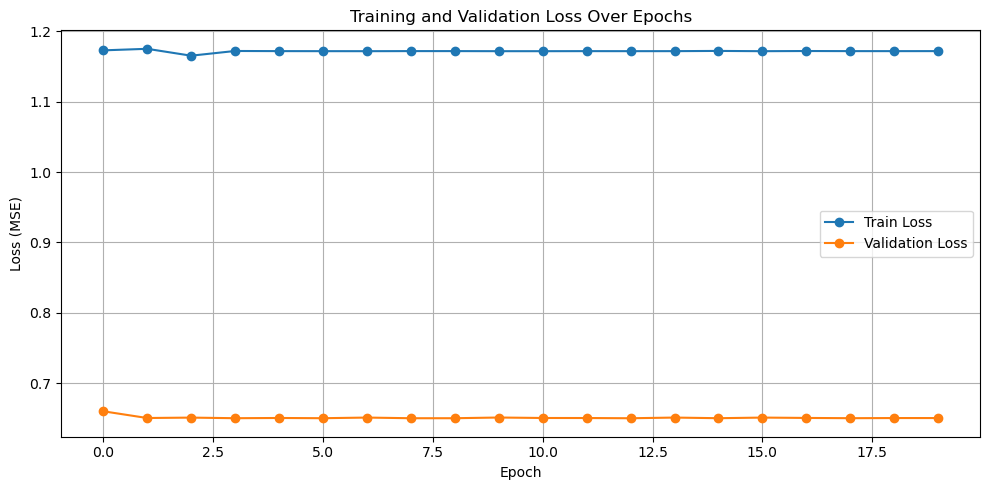

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Prediction

In [193]:
model = StockTransformer(input_dim=6,d_model=64 ,nhead=2,num_layers=2,dropout=0.1)
model.load_state_dict(torch.load("./stock_transformer.pth"))
model = model.to(device)  # 將模型移到GPU
model.eval()


StockTransformer(
  (feature_embedding): Linear(in_features=6, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [195]:
import random

# 隨機選擇多筆測試資料
num_samples = 5  # 要預測的樣本數
random_indices = random.sample(range(len(X_val)), num_samples)

x_test = X_val[random_indices]
y_test = y_val[random_indices]

x_input = torch.tensor(x_test).float()  # shape: (num_samples, 10, 6) 
x_input = x_input.to(device)  # 將輸入數據移到GPU

with torch.no_grad():
    predictions = model(x_input)
    
    for i in range(num_samples):
        print(f"\n樣本 {i+1}:")
        print(f"預測漲跌幅: {predictions[i].item():}")
        print(f"實際漲跌幅: {y_test[i].item():}")
        print("預測與實際漲跌趨勢是否相同:", 
              (predictions[i].item() > 0 and y_test[i].item() > 0) or 
              (predictions[i].item() < 0 and y_test[i].item() < 0))





樣本 1:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.18438556790351868
預測與實際漲跌趨勢是否相同: True

樣本 2:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: -0.2848852872848511
預測與實際漲跌趨勢是否相同: False

樣本 3:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.036533113569021225
預測與實際漲跌趨勢是否相同: True

樣本 4:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.05196119472384453
預測與實際漲跌趨勢是否相同: True

樣本 5:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.04938985034823418
預測與實際漲跌趨勢是否相同: True


/tmp/ipykernel_333078/3144996874.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_input = torch.tensor(x_test).float()  # shape: (num_samples, 10, 6)


In [157]:
x_test

tensor([[[ 0.2426,  0.2477,  0.2346,  0.2476, -0.3164,  0.1008],
         [ 0.2399,  0.2477,  0.2346,  0.2532, -0.3409,  0.0365],
         [ 0.2454,  0.2505,  0.2373,  0.2560, -0.3403,  0.1008],
         [ 0.2481,  0.2394,  0.2373,  0.2476, -0.2966, -0.2206],
         [ 0.2371,  0.2394,  0.2319,  0.2476, -0.3178,  0.0365],
         [ 0.2316,  0.2256,  0.2211,  0.2335, -0.2299, -0.2849],
         [ 0.2261,  0.2312,  0.2238,  0.2363, -0.3099,  0.1651],
         [ 0.2316,  0.2339,  0.2238,  0.2419, -0.3262,  0.1008],
         [ 0.2344,  0.2394,  0.2265,  0.2448, -0.3385,  0.1651],
         [ 0.2371,  0.2422,  0.2292,  0.2448, -0.3099,  0.1008]],

        [[ 0.6138,  0.6696,  0.6637,  0.6205,  0.1673,  2.0293],
         [ 0.6742,  0.6255,  0.6610,  0.5785,  0.0252, -0.9920],
         [ 0.6028,  0.6861,  0.6826,  0.6233, -0.0771,  1.4508],
         [ 0.6385,  0.5979,  0.6232,  0.6065,  0.3832, -2.0205],
         [ 0.6220,  0.6034,  0.6044,  0.6149, -0.2568,  0.1651],
         [ 0.6000,  0.5